# ***Allen's interval algebra***

## ***Import required packages***

In [76]:
try:
  import pm4py
  
except:
  !pip install -U pm4py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import scipy

from typing import Tuple
from matplotlib.patches import Rectangle
from pm4py import discover_bpmn_inductive
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

## ***Import the event log and convert it into the data frame***

In [10]:
log = xes_importer.apply("exercise6.xes")
el_df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
el_df.head()

parsing log, completed traces ::   0%|          | 0/132 [00:00<?, ?it/s]

,org:resource,time:timestamp,concept:name,lifecycle:transition,case:concept:name
0,Call Centre Agent,2005-12-31 23:00:00+00:00,check if sufficient information is available,start,0
1,Call Centre Agent,2006-01-13 23:00:00+00:00,check if sufficient information is available,complete,0
2,Call Centre Agent,2006-01-13 23:00:00+00:00,register claim,start,0
3,Call Centre Agent,2008-01-29 23:00:00+00:00,register claim,complete,0
4,Claims handler,2008-01-29 23:00:00+00:00,determine likelihood of claim,start,0


## ***Clean the event log***

In [119]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
  df["start_ts"] = df[df["lifecycle:transition"] == "start"]["time:timestamp"].map(lambda t: t.timestamp())
  df["complete_ts"] = df[df["lifecycle:transition"] == "complete"]["time:timestamp"].map(lambda t: t.timestamp())
  df.drop(["org:resource", "lifecycle:transition", "time:timestamp"], axis=1, inplace=True)
  df = df.rename(columns={"concept:name": "task_name", "case:concept:name": "case_id"})
  df = df[["case_id", "task_name", "start_ts", "complete_ts"]]
  df = df.groupby(["case_id", "task_name"], as_index=False).agg({"start_ts": "first", "complete_ts": "last"})
  df["interval_ts"] = df["complete_ts"] - df["start_ts"]
  df.sort_values("case_id", inplace=True)

  return df


el_df_cleaned = clean(el_df.copy())
el_df_cleaned.head()

,case_id,task_name,start_ts,complete_ts,interval_ts
0,0,advise claimant on reimbursement,1.288566e+09,1.335136e+09,46569600.0
1,0,assess claim,1.205795e+09,1.286924e+09,81129600.0
2,0,check if sufficient information is available,1.136070e+09,1.137193e+09,1123200.0
3,0,close claim,1.335136e+09,1.335481e+09,345600.0
4,0,determine likelihood of claim,1.201648e+09,1.205795e+09,4147200.0


## ***Display all tasks***

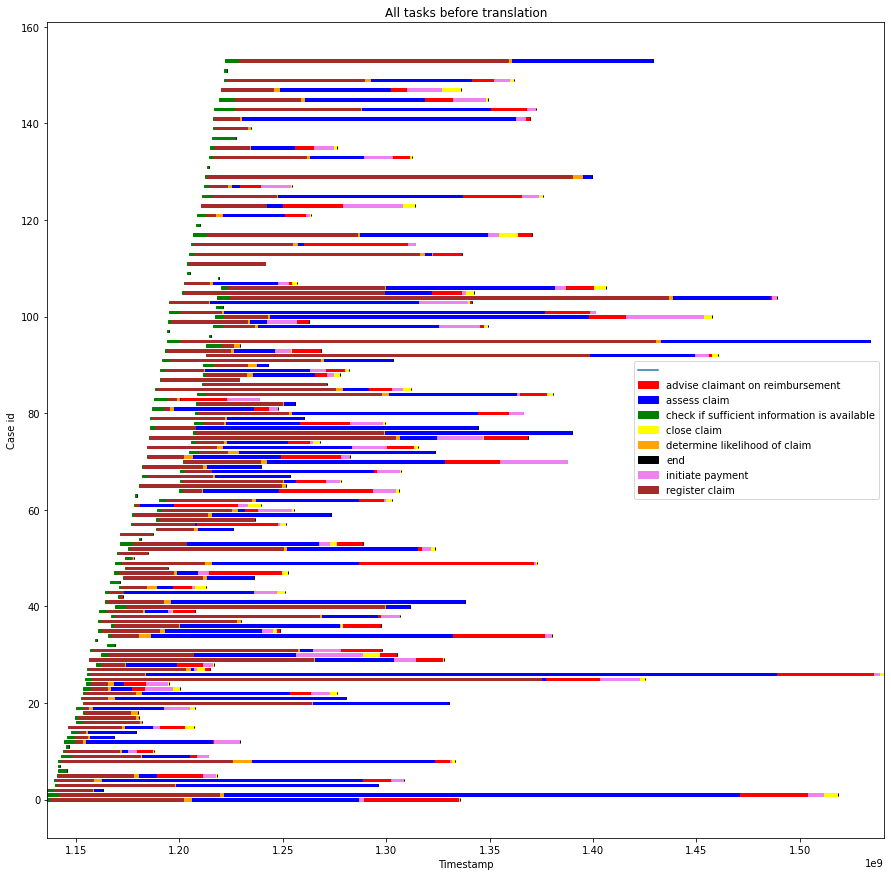

In [120]:
def display_all_tasks(df: pd.DataFrame, title: str) -> None:
  _, ax = plt.subplots(figsize=(15, 15))
  ax.plot([0, 10], [0, 10])
  colors_mapping = {"advise claimant on reimbursement": "red", "assess claim": "blue",
                    "check if sufficient information is available": "green",
                    "close claim": "yellow", "determine likelihood of claim": "orange",
                    "end": "black", "initiate payment": "violet", "register claim": "brown"}

  for i in range(len(df)):
    case_id = int(df["case_id"][i])
    task_name = df["task_name"][i]
    start_ts = df["start_ts"][i]
    interval_ts = df["interval_ts"][i]
    color = colors_mapping[task_name]
    ax.add_patch(Rectangle((start_ts, case_id - 0.25), interval_ts, 0.5, color=color))

  plt.xlim([df["start_ts"].min(), df["start_ts"].max()])
  plt.legend(["", "advise claimant on reimbursement", "assess claim",
              "check if sufficient information is available", "close claim",
              "determine likelihood of claim", "end", "initiate payment",
              "register claim"])
  plt.xlabel("Timestamp"), plt.ylabel("Case id")
  plt.title(title)
  plt.show()


display_all_tasks(el_df_cleaned, "All tasks before translation")

## ***Translate all tasks***

In [122]:
def translate(df: pd.DataFrame) -> pd.DataFrame:
  start_timestamps = {}

  for i in range(len(df)):
    case_id = df["case_id"][i]
    start_ts = df["start_ts"][i]

    if not case_id in start_timestamps:
      start_timestamps[case_id] = start_ts

    else:
      if start_ts < start_timestamps[case_id]:
        start_timestamps[case_id] = start_ts

  start_ts_list = []
  complete_ts_list = []

  for i in range(len(df)):
    case_id = df["case_id"][i]
    start_ts = start_timestamps[case_id]
    start_ts_list.append(df["start_ts"][i] - start_ts)
    complete_ts_list.append(df["complete_ts"][i] - start_ts)

  df["start_ts"] = start_ts_list
  df["complete_ts"] = complete_ts_list

  return df


el_df_translated = translate(el_df_cleaned.copy())
el_df_translated.head()

,case_id,task_name,start_ts,complete_ts,interval_ts
0,0,advise claimant on reimbursement,152496000.0,199065600.0,46569600.0
1,0,assess claim,69724800.0,150854400.0,81129600.0
2,0,check if sufficient information is available,0.0,1123200.0,1123200.0
3,0,close claim,199065600.0,199411200.0,345600.0
4,0,determine likelihood of claim,65577600.0,69724800.0,4147200.0


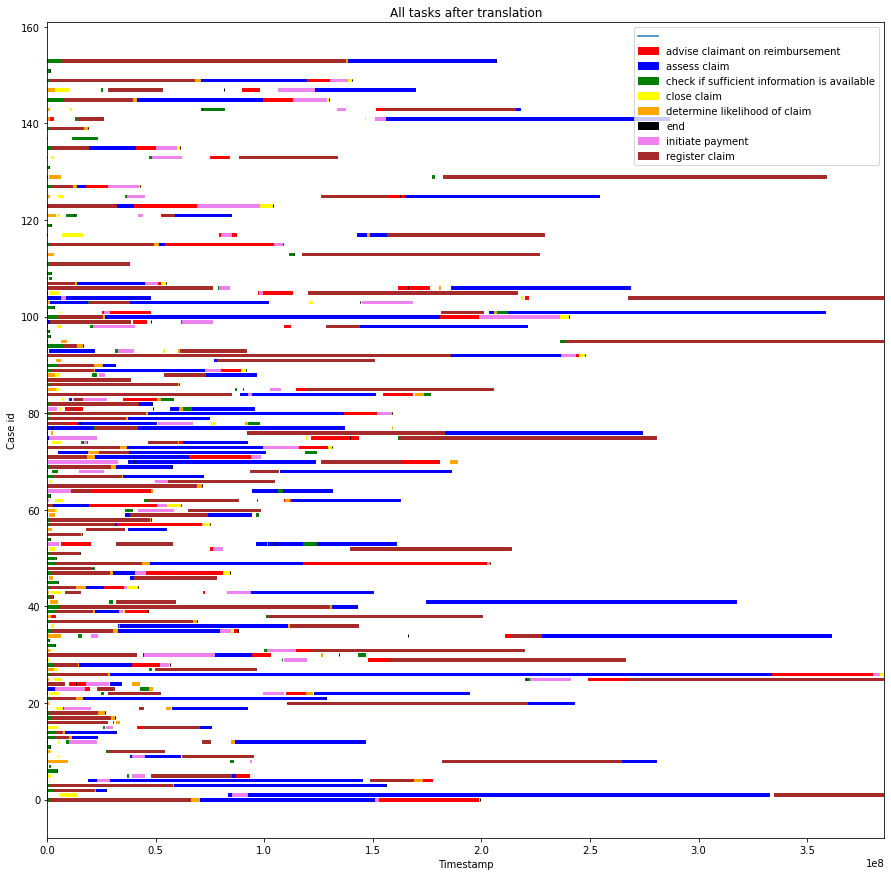

In [123]:
display_all_tasks(el_df_translated, "All tasks after translation")

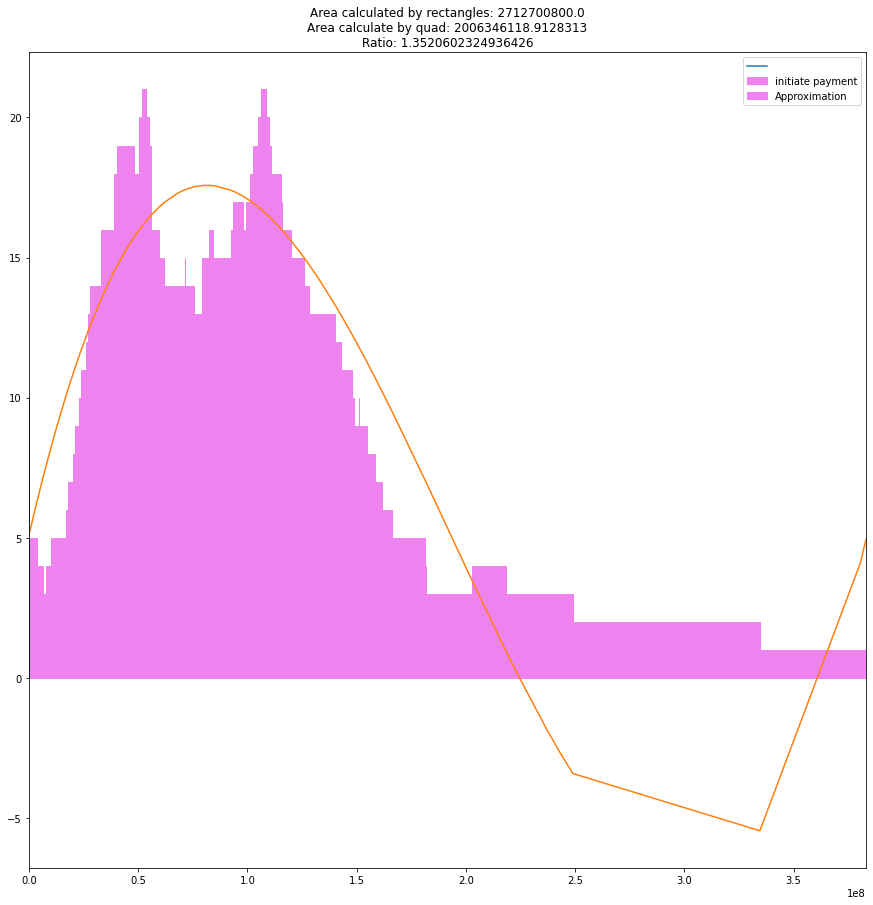

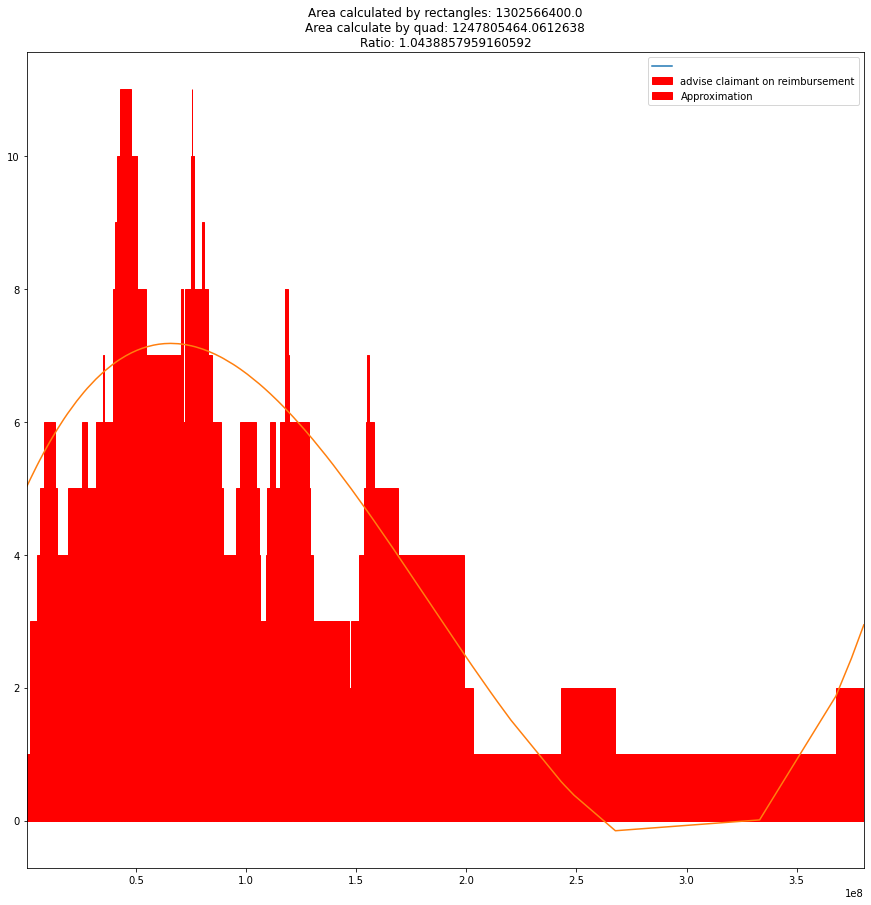

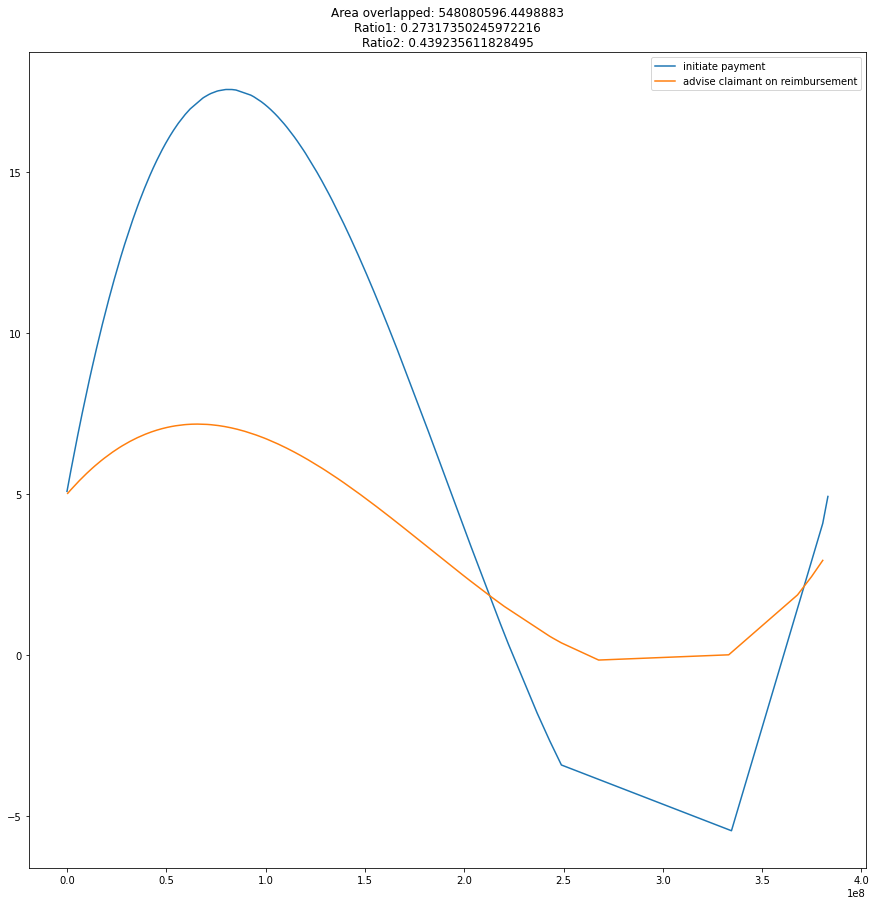

In [143]:
class Task:
  def __init__(self, name: str, color: str) -> None:
    self.name = name
    self.color = color
    self.timestamps = None
    self.frequencies = None
    self.coef = None
    self.area_rect = None
    self.area_quad = None


class AllenAnalysis:
  def __init__(self, df: pd.DataFrame, task1: Task, task2: Task, degree: int) -> None:
    self.df = df
    self.task1 = task1
    self.task2 = task2
    self.degree = degree
    self.area_overlapped = None
    self.combine_task_intervals(self.task1)
    self.combine_task_intervals(self.task2)
    self.approximate(self.task1)
    self.approximate(self.task2)

  def combine_task_intervals(self, task: Task) -> None:
    df = self.df[self.df["task_name"] == task.name].reset_index()
    timestamps = np.array(sorted(list(df["start_ts"]) + list(df["complete_ts"])))
    frequencies = np.array([0] * len(timestamps))

    for i in range(len(df)):
      start_ts = df["start_ts"][i]
      complete_ts = df["complete_ts"][i]
      start_idx = list(timestamps).index(start_ts)
      complete_idx = list(timestamps).index(complete_ts)

      for j in range(start_idx, complete_idx + 1):
        frequencies[j] = frequencies[j] + 1

    task.timestamps = timestamps
    task.frequencies = frequencies

  def approximate(self, task: Task) -> None:
    coef = np.polyfit(task.timestamps, task.frequencies, deg=self.degree)
    area_rect = 0

    for i in range(len(task.timestamps) - 1):
      area_rect += (task.timestamps[i + 1] - task.timestamps[i]) * task.frequencies[i]

    area_quad = scipy.integrate.quad(lambda x, p=coef: np.polyval(p, x), 0, task.timestamps[-1])[0]
    _, ax = plt.subplots(figsize=(15, 15))
    ax.plot([0, 10], [0, 10])

    for i in range(len(task.timestamps) - 1):
      t1 = task.timestamps[i]
      t2 = task.timestamps[i + 1]
      freq = task.frequencies[i]
      ax.add_patch(Rectangle((t1, 0), t2 - t1, freq, color=task.color))

    plt.legend(["", task.name, "Approximation"])
    plt.plot(task.timestamps, np.polyval(coef, task.timestamps))
    plt.xlim([min(task.timestamps), max(task.timestamps)])
    plt.title(f"Area calculated by rectangles: {area_rect}\nArea calculate by quad: {area_quad}\nRatio: {area_rect / area_quad}")
    plt.show()

    task.coef = coef
    task.area_rect = area_rect
    task.area_quad = area_quad

  def overlap(self) -> None:
    conv_fun = lambda x, p1=task1.coef, p2=task2.coef: min([np.polyval(p1, x), np.polyval(p2, x)])
    self.area_overlapped = scipy.integrate.quad(conv_fun, 0, min([task1.timestamps[-1], task2.timestamps[-1]]))[0]
    title = f"Area overlapped: {self.area_overlapped}\n"
    title += f"Ratio1: {self.area_overlapped / self.task1.area_quad}\n"
    title += f"Ratio2: {self.area_overlapped / self.task2.area_quad}"

    plt.figure(figsize=(15, 15))
    plt.plot(task1.timestamps, np.polyval(task1.coef, task1.timestamps))
    plt.plot(task2.timestamps, np.polyval(task2.coef, task2.timestamps))
    plt.legend([task1.name, task2.name])
    plt.title(title)
    plt.show()


task1 = Task("initiate payment", "violet")
task2 = Task("advise claimant on reimbursement", "red")
aa = AllenAnalysis(el_df_translated.copy(), task1, task2, 3)
aa.overlap()

In [ ]:
# try:
#   os.remove("/content/event_log.xes.gz")
#   os.remove("/content/event_log.xes")

# except:
#   pass
  
# !wget -O "/content/event_log.xes.gz" https://data.4tu.nl/file/6af6d5f0-f44c-49be-aac8-8eaa5fe4f6fd/28b83e72-375e-4da4-8459-a8506e898edf
# os.system('gzip -dk event_log.xes.gz')

# el = xes_importer.apply("/content/event_log.xes")
# el_df = log_converter.apply(el, variant=log_converter.Variants.TO_DATA_FRAME)
# el_df.head()


# !wget -O "/content/event_log.csv" https://data.4tu.nl/file/e9c00fe9-c87a-450e-8bd6-d5e06a6b309a/9d7cd406-9826-4adf-8418-c751b475f556

# el_df = pd.read_csv("/content/event_log.csv", sep=";")
# el_df.head()